In [10]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel, Field
import operator
from typing import TypedDict,Annotated
import dotenv
import os
from langchain.chat_models import init_chat_model
dotenv.load_dotenv() 

True

In [11]:
custom_profile = {
    "structured_output": True,
    # ...
}
os.environ["GOOGLE_API_KEY"] = os.getenv("GOOGLE_API_KEY","")
    
model = init_chat_model("google_genai:gemini-2.5-flash-lite", profile=custom_profile)

In [12]:
class EssaySchema(BaseModel):
    feedback: str = Field(..., description="The feedback for the essay.")
    score: int = Field(..., description="The score for the essay it range of 1-10.",ge=1, le=10)
    

In [13]:
structured_model = model.with_structured_output(EssaySchema)
structured_model


RunnableBinding(bound=ChatGoogleGenerativeAI(profile={'structured_output': True}, google_api_key=SecretStr('**********'), model='gemini-2.5-flash-lite', client=<google.genai.client.Client object at 0x0000017865CD0F90>, default_metadata=(), model_kwargs={}), kwargs={'response_mime_type': 'application/json', 'response_json_schema': {'properties': {'feedback': {'description': 'The feedback for the essay.', 'title': 'Feedback', 'type': 'string'}, 'score': {'description': 'The score for the essay it range of 1-10.', 'maximum': 10, 'minimum': 1, 'title': 'Score', 'type': 'integer'}}, 'required': ['feedback', 'score'], 'title': 'EssaySchema', 'type': 'object'}, 'ls_structured_output_format': {'kwargs': {'method': 'json_schema'}, 'schema': {'title': 'EssaySchema', 'description': '', 'properties': {'feedback': {'description': 'The feedback for the essay.', 'type': 'string'}, 'score': {'description': 'The score for the essay it range of 1-10.', 'maximum': 10, 'minimum': 1, 'type': 'integer'}}, '

In [14]:
essay = """In today's rapidly evolving world, technology plays a pivotal role in shaping our lives. From communication to transportation, advancements in technology have revolutionized the way we interact with the world around us. 
The integration of artificial intelligence and machine learning has further accelerated this transformation, enabling us to solve complex problems and improve efficiency across various sectors.
However, it is essential to strike a balance between embracing technological innovations and addressing the ethical implications they bring forth.
As we continue to navigate this digital age, fostering responsible innovation will be key to ensuring that technology serves as a force for good, enhancing human potential and societal well-being."""


In [15]:
prompt = """Please rate the following essay and provide feedback and assign a score out of 10. \n {essay}"""

In [16]:
structured_model.invoke(prompt)  

EssaySchema(feedback='The essay is well-structured and presents a clear argument. However, it could benefit from more in-depth analysis and stronger supporting evidence in a few areas. The introduction effectively sets the stage, and the conclusion summarizes the main points adequately. To improve, consider expanding on the implications of your findings and addressing potential counterarguments more thoroughly.', score=7)

In [17]:
class EssayInputState(TypedDict):
    essay: str
    language_feedback: str
    analysis_feedback: str
    clarity_feedback: str
    overall_feedback: str
    individual_scores: Annotated[list[int], operator.add]
    avg_score: float
    

In [18]:
def evaluate_language(state: EssayInputState):
    prompt = """Evaluate the language quality of the Please rate the following essay and provide feedback and assign a score out of 10. \n {state['essay']}"""
    result = structured_model.invoke(prompt)
    return {
        "language_feedback": result.feedback,   
        "individual_scores": [result.score]
    }

In [19]:
def evaluate_analysis(state: EssayInputState):
    prompt = """Evaluate the analytical depth of the Please rate the following essay and provide feedback and assign a score out of 10. \n {state['essay']}"""
    result = structured_model.invoke(prompt)
    return {
        "analysis_feedback": result.feedback,   
        "individual_scores": [result.score]
    }

In [20]:
def evaluate_clarity(state: EssayInputState):
    prompt = f"""Evaluate the clarity of the Please rate the following essay and provide feedback and assign a score out of 10. \n {state['essay']}"""
    result = structured_model.invoke(prompt)
    return {
        "clarity_feedback": result.feedback,   
        "individual_scores": [result.score]
    }

In [21]:
def final_evaluation(state: EssayInputState):
    prompt = f'Based on following feedbacks: Language: {state["language_feedback"]}, Analysis: {state["analysis_feedback"]}, Clarity: {state["clarity_feedback"]}, provide an overall evaluation of the essay.'
    
    overall_feedback = model.invoke(prompt)
    
    ### Calculate average score
    avg_score = sum(state["individual_scores"]) / len(state["individual_scores"])
    return {
        "overall_feedback": overall_feedback,
        "avg_score": avg_score
    }

In [24]:
graph = StateGraph(EssayInputState)

graph.add_node("evaluate_language",evaluate_language)
graph.add_node("evaluate_analysis",evaluate_analysis)
graph.add_node("evaluate_clarity",evaluate_clarity)
graph.add_node("final_evaluation",final_evaluation)

In [26]:
graph.add_edge(START, "evaluate_language")
graph.add_edge(START, "evaluate_analysis")  
graph.add_edge(START, "evaluate_clarity")
graph.add_edge("evaluate_language", "final_evaluation")
graph.add_edge("evaluate_analysis", "final_evaluation")
graph.add_edge("evaluate_clarity", "final_evaluation")
graph.add_edge("final_evaluation", END)

In [ ]:
workflow = graph.compile()



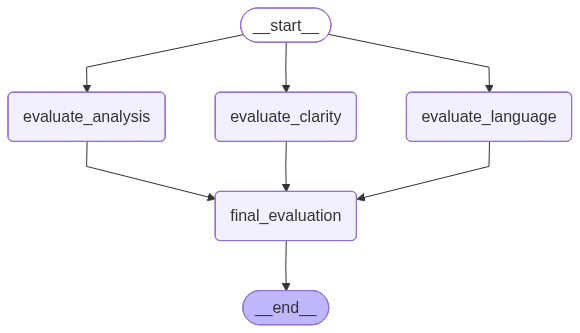

In [29]:
workflow

In [31]:
essay2 = """India and AI Time

Now world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.

India have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.

In farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.

But problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.

One more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.

India must all people together – govern, school, company and normal people. We teach AI and make sure AI not bad. Also talk to other country and learn from them.

If India use AI good way, we become strong, help poor and make better life. But if only rich use AI, and poor no get, then big bad thing happen.

So, in short, AI time in India have many hope and many danger. We must go right road. AI must help all people, not only some. Then India grow big and world say "good job India"."""

In [32]:
intput_state = {
    "essay": essay2
}

In [34]:
final_workflow = workflow.invoke(intput_state)
final_workflow

{'essay': 'India and AI Time\n\nNow world change very fast because new tech call Artificial Intel… something (AI). India also want become big in this AI thing. If work hard, India can go top. But if no careful, India go back.\n\nIndia have many good. We have smart student, many engine-ear, and good IT peoples. Big company like TCS, Infosys, Wipro already use AI. Government also do program “AI for All”. It want AI in farm, doctor place, school and transport.\n\nIn farm, AI help farmer know when to put seed, when rain come, how stop bug. In health, AI help doctor see sick early. In school, AI help student learn good. Government office use AI to find bad people and work fast.\n\nBut problem come also. First is many villager no have phone or internet. So AI not help them. Second, many people lose job because AI and machine do work. Poor people get more bad.\n\nOne more big problem is privacy. AI need big big data. Who take care? India still make data rule. If no strong rule, AI do bad.\n\n

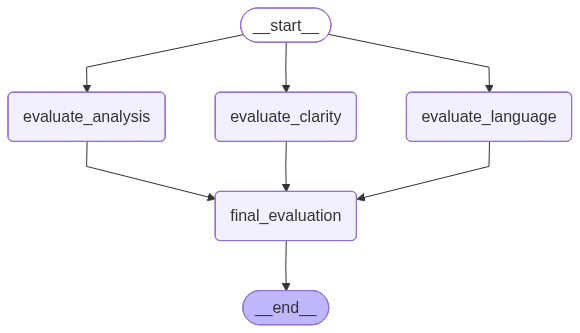

In [35]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())